# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:14 - loss: 0.6924

  31/1875 [..............................] - ETA: 3s - loss: 0.5281   

  64/1875 [>.............................] - ETA: 2s - loss: 0.4474

  98/1875 [>.............................] - ETA: 2s - loss: 0.4057

 134/1875 [=>............................] - ETA: 2s - loss: 0.3784

 170/1875 [=>............................] - ETA: 2s - loss: 0.3590

 204/1875 [==>...........................] - ETA: 2s - loss: 0.3447

 241/1875 [==>...........................] - ETA: 2s - loss: 0.3320

 274/1875 [===>..........................] - ETA: 2s - loss: 0.3224

 310/1875 [===>..........................] - ETA: 2s - loss: 0.3134

 345/1875 [====>.........................] - ETA: 2s - loss: 0.3057

 382/1875 [=====>........................] - ETA: 2s - loss: 0.2984

 409/1875 [=====>........................] - ETA: 2s - loss: 0.2936

 443/1875 [======>.......................] - ETA: 2s - loss: 0.2881

 475/1875 [======>.......................] - ETA: 2s - loss: 0.2833

 501/1875 [=======>......................] - ETA: 2s - loss: 0.2797

 533/1875 [=======>......................] - ETA: 2s - loss: 0.2755

 557/1875 [=======>......................] - ETA: 2s - loss: 0.2726

 591/1875 [========>.....................] - ETA: 1s - loss: 0.2687

 629/1875 [=========>....................] - ETA: 1s - loss: 0.2646

 661/1875 [=========>....................] - ETA: 1s - loss: 0.2614

 691/1875 [==========>...................] - ETA: 1s - loss: 0.2585

 722/1875 [==========>...................] - ETA: 1s - loss: 0.2557

 752/1875 [===========>..................] - ETA: 1s - loss: 0.2531

 781/1875 [===========>..................] - ETA: 1s - loss: 0.2507

 813/1875 [============>.................] - ETA: 1s - loss: 0.2482

 844/1875 [============>.................] - ETA: 1s - loss: 0.2459

 877/1875 [=============>................] - ETA: 1s - loss: 0.2435

 912/1875 [=============>................] - ETA: 1s - loss: 0.2411

 950/1875 [==============>...............] - ETA: 1s - loss: 0.2386

 988/1875 [==============>...............] - ETA: 1s - loss: 0.2363

1023/1875 [===============>..............] - ETA: 1s - loss: 0.2342

1054/1875 [===============>..............] - ETA: 1s - loss: 0.2324

1088/1875 [================>.............] - ETA: 1s - loss: 0.2305

1120/1875 [================>.............] - ETA: 1s - loss: 0.2288

1151/1875 [=================>............] - ETA: 1s - loss: 0.2272

1188/1875 [==================>...........] - ETA: 1s - loss: 0.2254

1225/1875 [==================>...........] - ETA: 0s - loss: 0.2236

1262/1875 [===================>..........] - ETA: 0s - loss: 0.2219

1296/1875 [===================>..........] - ETA: 0s - loss: 0.2204

1322/1875 [====================>.........] - ETA: 0s - loss: 0.2193

1352/1875 [====================>.........] - ETA: 0s - loss: 0.2180

1382/1875 [=====================>........] - ETA: 0s - loss: 0.2168

1414/1875 [=====================>........] - ETA: 0s - loss: 0.2155

1444/1875 [======================>.......] - ETA: 0s - loss: 0.2143

1477/1875 [======================>.......] - ETA: 0s - loss: 0.2131

1508/1875 [=======================>......] - ETA: 0s - loss: 0.2120

1537/1875 [=======================>......] - ETA: 0s - loss: 0.2109

1568/1875 [========================>.....] - ETA: 0s - loss: 0.2098

1597/1875 [========================>.....] - ETA: 0s - loss: 0.2088

1627/1875 [=========================>....] - ETA: 0s - loss: 0.2078

1658/1875 [=========================>....] - ETA: 0s - loss: 0.2068

1688/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1717/1875 [==========================>...] - ETA: 0s - loss: 0.2050

1747/1875 [==========================>...] - ETA: 0s - loss: 0.2040

1779/1875 [===========================>..] - ETA: 0s - loss: 0.2031

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2022

1841/1875 [============================>.] - ETA: 0s - loss: 0.2013

1870/1875 [============================>.] - ETA: 0s - loss: 0.2005

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2003


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1163

  32/1875 [..............................] - ETA: 2s - loss: 0.1094

  62/1875 [..............................] - ETA: 3s - loss: 0.1092

  92/1875 [>.............................] - ETA: 3s - loss: 0.1091

 121/1875 [>.............................] - ETA: 2s - loss: 0.1091

 148/1875 [=>............................] - ETA: 2s - loss: 0.1092

 176/1875 [=>............................] - ETA: 2s - loss: 0.1091

 206/1875 [==>...........................] - ETA: 2s - loss: 0.1091

 235/1875 [==>...........................] - ETA: 2s - loss: 0.1091

 266/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 294/1875 [===>..........................] - ETA: 2s - loss: 0.1090

 323/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 353/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 382/1875 [=====>........................] - ETA: 2s - loss: 0.1089

 412/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 440/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 469/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 500/1875 [=======>......................] - ETA: 2s - loss: 0.1086

 531/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 561/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 593/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 621/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 651/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 683/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 713/1875 [==========>...................] - ETA: 2s - loss: 0.1082

 742/1875 [==========>...................] - ETA: 1s - loss: 0.1081

 766/1875 [===========>..................] - ETA: 1s - loss: 0.1081

 797/1875 [===========>..................] - ETA: 1s - loss: 0.1080

 824/1875 [============>.................] - ETA: 1s - loss: 0.1079

 847/1875 [============>.................] - ETA: 1s - loss: 0.1079

 875/1875 [=============>................] - ETA: 1s - loss: 0.1078

 900/1875 [=============>................] - ETA: 1s - loss: 0.1078

 929/1875 [=============>................] - ETA: 1s - loss: 0.1077

 957/1875 [==============>...............] - ETA: 1s - loss: 0.1077

 980/1875 [==============>...............] - ETA: 1s - loss: 0.1077

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1038/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1070/1875 [================>.............] - ETA: 1s - loss: 0.1075

1102/1875 [================>.............] - ETA: 1s - loss: 0.1074

1133/1875 [=================>............] - ETA: 1s - loss: 0.1074

1162/1875 [=================>............] - ETA: 1s - loss: 0.1073

1193/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1224/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1254/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1285/1875 [===================>..........] - ETA: 1s - loss: 0.1071

1315/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1345/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1375/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1405/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1436/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1467/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1528/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1560/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1591/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1623/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1655/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1688/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1721/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1753/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1785/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1817/1875 [============================>.] - ETA: 0s - loss: 0.1062

1849/1875 [============================>.] - ETA: 0s - loss: 0.1062

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1061


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1072

  32/1875 [..............................] - ETA: 2s - loss: 0.0980

  62/1875 [..............................] - ETA: 2s - loss: 0.0981

  93/1875 [>.............................] - ETA: 2s - loss: 0.0983

 124/1875 [>.............................] - ETA: 2s - loss: 0.0983

 156/1875 [=>............................] - ETA: 2s - loss: 0.0983

 188/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 220/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 284/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 346/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0985

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0985

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0985

 509/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 637/1875 [=========>....................] - ETA: 1s - loss: 0.0985

 667/1875 [=========>....................] - ETA: 1s - loss: 0.0985

 698/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 730/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 763/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 796/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 829/1875 [============>.................] - ETA: 1s - loss: 0.0984

 861/1875 [============>.................] - ETA: 1s - loss: 0.0984

 892/1875 [=============>................] - ETA: 1s - loss: 0.0984

 925/1875 [=============>................] - ETA: 1s - loss: 0.0984

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 990/1875 [==============>...............] - ETA: 1s - loss: 0.0984

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1054/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1086/1875 [================>.............] - ETA: 1s - loss: 0.0984

1119/1875 [================>.............] - ETA: 1s - loss: 0.0983

1152/1875 [=================>............] - ETA: 1s - loss: 0.0983

1183/1875 [=================>............] - ETA: 1s - loss: 0.0983

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0983

1247/1875 [==================>...........] - ETA: 0s - loss: 0.0983

1280/1875 [===================>..........] - ETA: 0s - loss: 0.0983

1313/1875 [====================>.........] - ETA: 0s - loss: 0.0983

1346/1875 [====================>.........] - ETA: 0s - loss: 0.0983

1376/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0982

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0982

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0982

1529/1875 [=======================>......] - ETA: 0s - loss: 0.0982

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0982

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0981

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0981

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0981

1834/1875 [============================>.] - ETA: 0s - loss: 0.0981

1864/1875 [============================>.] - ETA: 0s - loss: 0.0981

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0981


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0987

  29/1875 [..............................] - ETA: 3s - loss: 0.0933

  59/1875 [..............................] - ETA: 3s - loss: 0.0944

  87/1875 [>.............................] - ETA: 3s - loss: 0.0949

 110/1875 [>.............................] - ETA: 3s - loss: 0.0952

 135/1875 [=>............................] - ETA: 3s - loss: 0.0954

 161/1875 [=>............................] - ETA: 3s - loss: 0.0955

 191/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 255/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 287/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 349/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 380/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 537/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 695/1875 [==========>...................] - ETA: 1s - loss: 0.0960

 726/1875 [==========>...................] - ETA: 1s - loss: 0.0960

 756/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 783/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 813/1875 [============>.................] - ETA: 1s - loss: 0.0960

 841/1875 [============>.................] - ETA: 1s - loss: 0.0960

 869/1875 [============>.................] - ETA: 1s - loss: 0.0960

 898/1875 [=============>................] - ETA: 1s - loss: 0.0960

 926/1875 [=============>................] - ETA: 1s - loss: 0.0960

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1042/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1066/1875 [================>.............] - ETA: 1s - loss: 0.0960

1091/1875 [================>.............] - ETA: 1s - loss: 0.0960

1118/1875 [================>.............] - ETA: 1s - loss: 0.0960

1145/1875 [=================>............] - ETA: 1s - loss: 0.0960

1174/1875 [=================>............] - ETA: 1s - loss: 0.0960

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1298/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1331/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1833/1875 [============================>.] - ETA: 0s - loss: 0.0960

1860/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1018

  33/1875 [..............................] - ETA: 2s - loss: 0.0948

  64/1875 [>.............................] - ETA: 2s - loss: 0.0949

  88/1875 [>.............................] - ETA: 3s - loss: 0.0949

 114/1875 [>.............................] - ETA: 3s - loss: 0.0949

 143/1875 [=>............................] - ETA: 3s - loss: 0.0949

 174/1875 [=>............................] - ETA: 3s - loss: 0.0950

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 236/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 266/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 326/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 357/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 387/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 508/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 601/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 632/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 696/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 728/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 760/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 823/1875 [============>.................] - ETA: 1s - loss: 0.0953

 854/1875 [============>.................] - ETA: 1s - loss: 0.0953

 885/1875 [=============>................] - ETA: 1s - loss: 0.0953

 914/1875 [=============>................] - ETA: 1s - loss: 0.0953

 945/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 979/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1088/1875 [================>.............] - ETA: 1s - loss: 0.0953

1116/1875 [================>.............] - ETA: 1s - loss: 0.0953

1141/1875 [=================>............] - ETA: 1s - loss: 0.0953

1169/1875 [=================>............] - ETA: 1s - loss: 0.0953

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1226/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1289/1875 [===================>..........] - ETA: 0s - loss: 0.0953

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1352/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1840/1875 [============================>.] - ETA: 0s - loss: 0.0953

1865/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

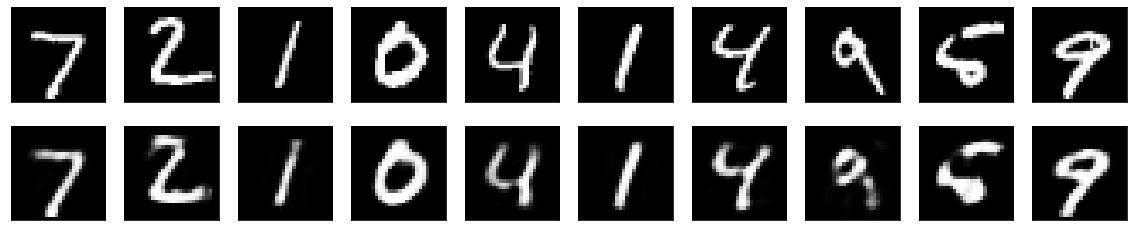

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
